In [3]:
%run matplotlib_setup.ipy
%run helper.ipy

In [4]:
graphene = kwant.lattice.general([[np.sqrt(3)/2,1/2],[np.sqrt(3)/2,-1/2]],  #Lattice vectors 
                                  [[0,0],[1/np.sqrt(3),0]]) # Co-ordinates
a,b = graphene.sublattices

In [18]:
Zigzag = kwant.lattice.general([[np.sqrt(3)/3,0],[0,1]], #Lattice vectors
                                     [[0,1/6],[np.sqrt(3)/2,2/6],[np.sqrt(3)/2,4/6],[0,5/6]]) # Coordinates
a,b,c,d = [0,0,0,0]

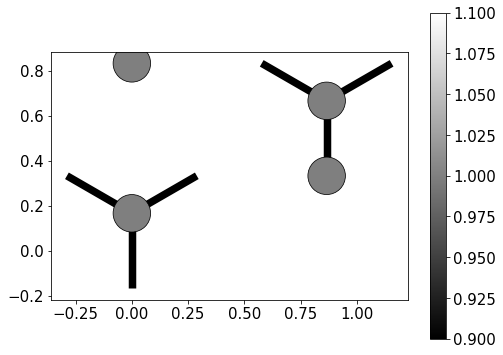

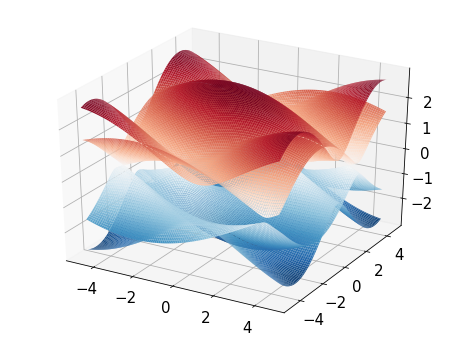

In [21]:
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*Zigzag.prim_vecs))
bulk_graphene[Zigzag.shape((lambda pos: True), (0, 0))] = 0
bulk_graphene[Zigzag.neighbors(1)] = 1
kwant.plot(bulk_graphene,site_color=family_color,site_lw=0.01)
dispersion_2D(wraparound(bulk_graphene).finalized())